In [1]:
import pandas as pd
import numpy as np
import math
import pickle

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold

import platform
from os import listdir
from os.path import isfile, join
from glob import glob
from pathlib import Path
import sys
import os
import copy
import traceback
from pathlib import Path


import matplotlib.pyplot as plt

import SMOTE
import feature_selector
import DE
import CFS
import birch
import metrics.abcd

import metrices
import measures

import sys
import traceback
import warnings

import seaborn as sns

%matplotlib inline
warnings.filterwarnings("ignore")

In [2]:
def prepare_data(path):
    df = pd.read_csv(path)
    df = df.drop(labels = ['Host','Vcs','Project','File','PL','IssueTracking'],axis=1)
    df = df.dropna()
    df = df[['TLOC', 'TNF', 'TNC', 'TND', 'LOC', 'CL', 'NStmt', 'NFunc',
       'RCC', 'MNL', 'avg_WMC', 'max_WMC', 'total_WMC', 'avg_DIT', 'max_DIT',
       'total_DIT', 'avg_RFC', 'max_RFC', 'total_RFC', 'avg_NOC', 'max_NOC',
       'total_NOC', 'avg_CBO', 'max_CBO', 'total_CBO', 'avg_DIT.1',
       'max_DIT.1', 'total_DIT.1', 'avg_NIV', 'max_NIV', 'total_NIV',
       'avg_NIM', 'max_NIM', 'total_NIM', 'avg_NOM', 'max_NOM', 'total_NOM',
       'avg_NPBM', 'max_NPBM', 'total_NPBM', 'avg_NPM', 'max_NPM', 'total_NPM',
       'avg_NPRM', 'max_NPRM', 'total_NPRM', 'avg_CC', 'max_CC', 'total_CC',
       'avg_FANIN', 'max_FANIN', 'total_FANIN', 'avg_FANOUT', 'max_FANOUT',
       'total_FANOUT', 'NRev', 'NFix', 'avg_AddedLOC', 'max_AddedLOC',
       'total_AddedLOC', 'avg_DeletedLOC', 'max_DeletedLOC',
       'total_DeletedLOC', 'avg_ModifiedLOC', 'max_ModifiedLOC',
       'total_ModifiedLOC','Buggy']]
    return df

def get_features(df):
    fs = feature_selector.featureSelector()
    df,_feature_nums,features = fs.cfs_bfs(df)
    return df,features

def apply_cfs(df):
    y = df.Buggy.values
    X = df.drop(labels = ['Buggy'],axis = 1)
    X = X.values
    selected_cols = CFS.cfs(X,y)
    cols = df.columns[[selected_cols]].tolist()
    cols.append('Buggy')
    return df[cols],cols
    
def apply_smote(df):
    cols = df.columns
    smt = SMOTE.smote(df)
    df = smt.run()
    df.columns = cols
    return df

def load_data(path,target):
    df = pd.read_csv(path)
    if path == 'data/jm1.csv':
        df = df[~df.uniq_Op.str.contains("\?")]
    y = df[target]
    X = df.drop(labels = target, axis = 1)
    X = X.apply(pd.to_numeric)
    return X,y

# Cluster Driver
def cluster_driver(df,print_tree = True):
    X = df.apply(pd.to_numeric)
    cluster = birch.birch(branching_factor=20)
    #X.set_index('Project Name',inplace=True)
    cluster.fit(X)
    cluster_tree,max_depth = cluster.get_cluster_tree()
    #cluster_tree = cluster.model_adder(cluster_tree)
    if print_tree:
        cluster.show_clutser_tree()
    return cluster,cluster_tree,max_depth

In [3]:
def get_predicted(cluster_data_loc,metrices_loc,fold,data_location):
    train_data = pd.read_pickle(cluster_data_loc + '/train_data.pkl')
    project = train_data.index.values.tolist()
    _s_path = '/Users/suvodeepmajumder/Documents/AI4SE/bellwether_comminity/data/1385/converted/' + project[0]
    s_df = prepare_data(_s_path)
    s_cols = s_df.columns
    train_data.columns = s_cols
    result = train_data.sum(axis = 0)
    return result.values.tolist(),s_cols

In [4]:
final_list = []
for i in range(1):
    fold = str(i)
    data_location = '/Users/suvodeepmajumder/Documents/AI4SE/bellwether_comminity/src/data/1385/exp_cdom_v6/fold_' + fold
    cluster_data_loc = '/Users/suvodeepmajumder/Documents/AI4SE/bellwether_comminity/src/data/1385/new_bellwether_pre_re_pf_v2/2/fold_' + fold
    metrices_loc = '/Users/suvodeepmajumder/Documents/AI4SE/bellwether_comminity/data/1385/converted'
    results,s_cols = get_predicted(cluster_data_loc,metrices_loc,fold,data_location)
    final_list.append(results)
final_df = pd.DataFrame(final_list,columns=s_cols)


In [5]:
final_df

,TLOC,TNF,TNC,TND,LOC,CL,NStmt,NFunc,RCC,MNL,...,avg_AddedLOC,max_AddedLOC,total_AddedLOC,avg_DeletedLOC,max_DeletedLOC,total_DeletedLOC,avg_ModifiedLOC,max_ModifiedLOC,total_ModifiedLOC,Buggy
0,20.0,0.0,0.0,0.0,145.0,274.0,152.0,117.0,205.0,150.0,...,159.0,151.0,177.0,153.0,147.0,180.0,165.0,174.0,174.0,627.0


In [6]:
items = {}
for i in range(final_df.iloc[0].shape[0]):
    x = final_df.iloc[0].index[i].split('_')
    if len(x) > 1:
        if x[1] not in items.keys():
            items[x[1]] = 0
        items[x[1]] = items[x[1]] + final_df.iloc[0].iloc[i]
    else:
        if x[0] not in items.keys():
            items[x[0]] = 0
        items[x[0]] = final_df.iloc[0].iloc[i]
    #print(final_df.iloc[0].index[i],final_df.iloc[0].iloc[i])
print((items))

{'TLOC': 20.0, 'TNF': 0.0, 'TNC': 0.0, 'TND': 0.0, 'LOC': 145.0, 'CL': 274.0, 'NStmt': 152.0, 'NFunc': 117.0, 'RCC': 205.0, 'MNL': 150.0, 'WMC': 181.0, 'DIT': 263.0, 'RFC': 229.0, 'NOC': 212.0, 'CBO': 349.0, 'DIT.1': 85.0, 'NIV': 304.0, 'NIM': 149.0, 'NOM': 113.0, 'NPBM': 207.0, 'NPM': 293.0, 'NPRM': 304.0, 'CC': 361.0, 'FANIN': 467.0, 'FANOUT': 436.0, 'NRev': 325.0, 'NFix': 356.0, 'AddedLOC': 487.0, 'DeletedLOC': 480.0, 'ModifiedLOC': 513.0, 'Buggy': 627.0}


In [7]:
items_df = pd.DataFrame.from_dict(items,orient='index',columns=['ob'])
print(items_df)

                ob
TLOC          20.0
TNF            0.0
TNC            0.0
TND            0.0
LOC          145.0
CL           274.0
NStmt        152.0
NFunc        117.0
RCC          205.0
MNL          150.0
WMC          181.0
DIT          263.0
RFC          229.0
NOC          212.0
CBO          349.0
DIT.1         85.0
NIV          304.0
NIM          149.0
NOM          113.0
NPBM         207.0
NPM          293.0
NPRM         304.0
CC           361.0
FANIN        467.0
FANOUT       436.0
NRev         325.0
NFix         356.0
AddedLOC     487.0
DeletedLOC   480.0
ModifiedLOC  513.0
Buggy        627.0


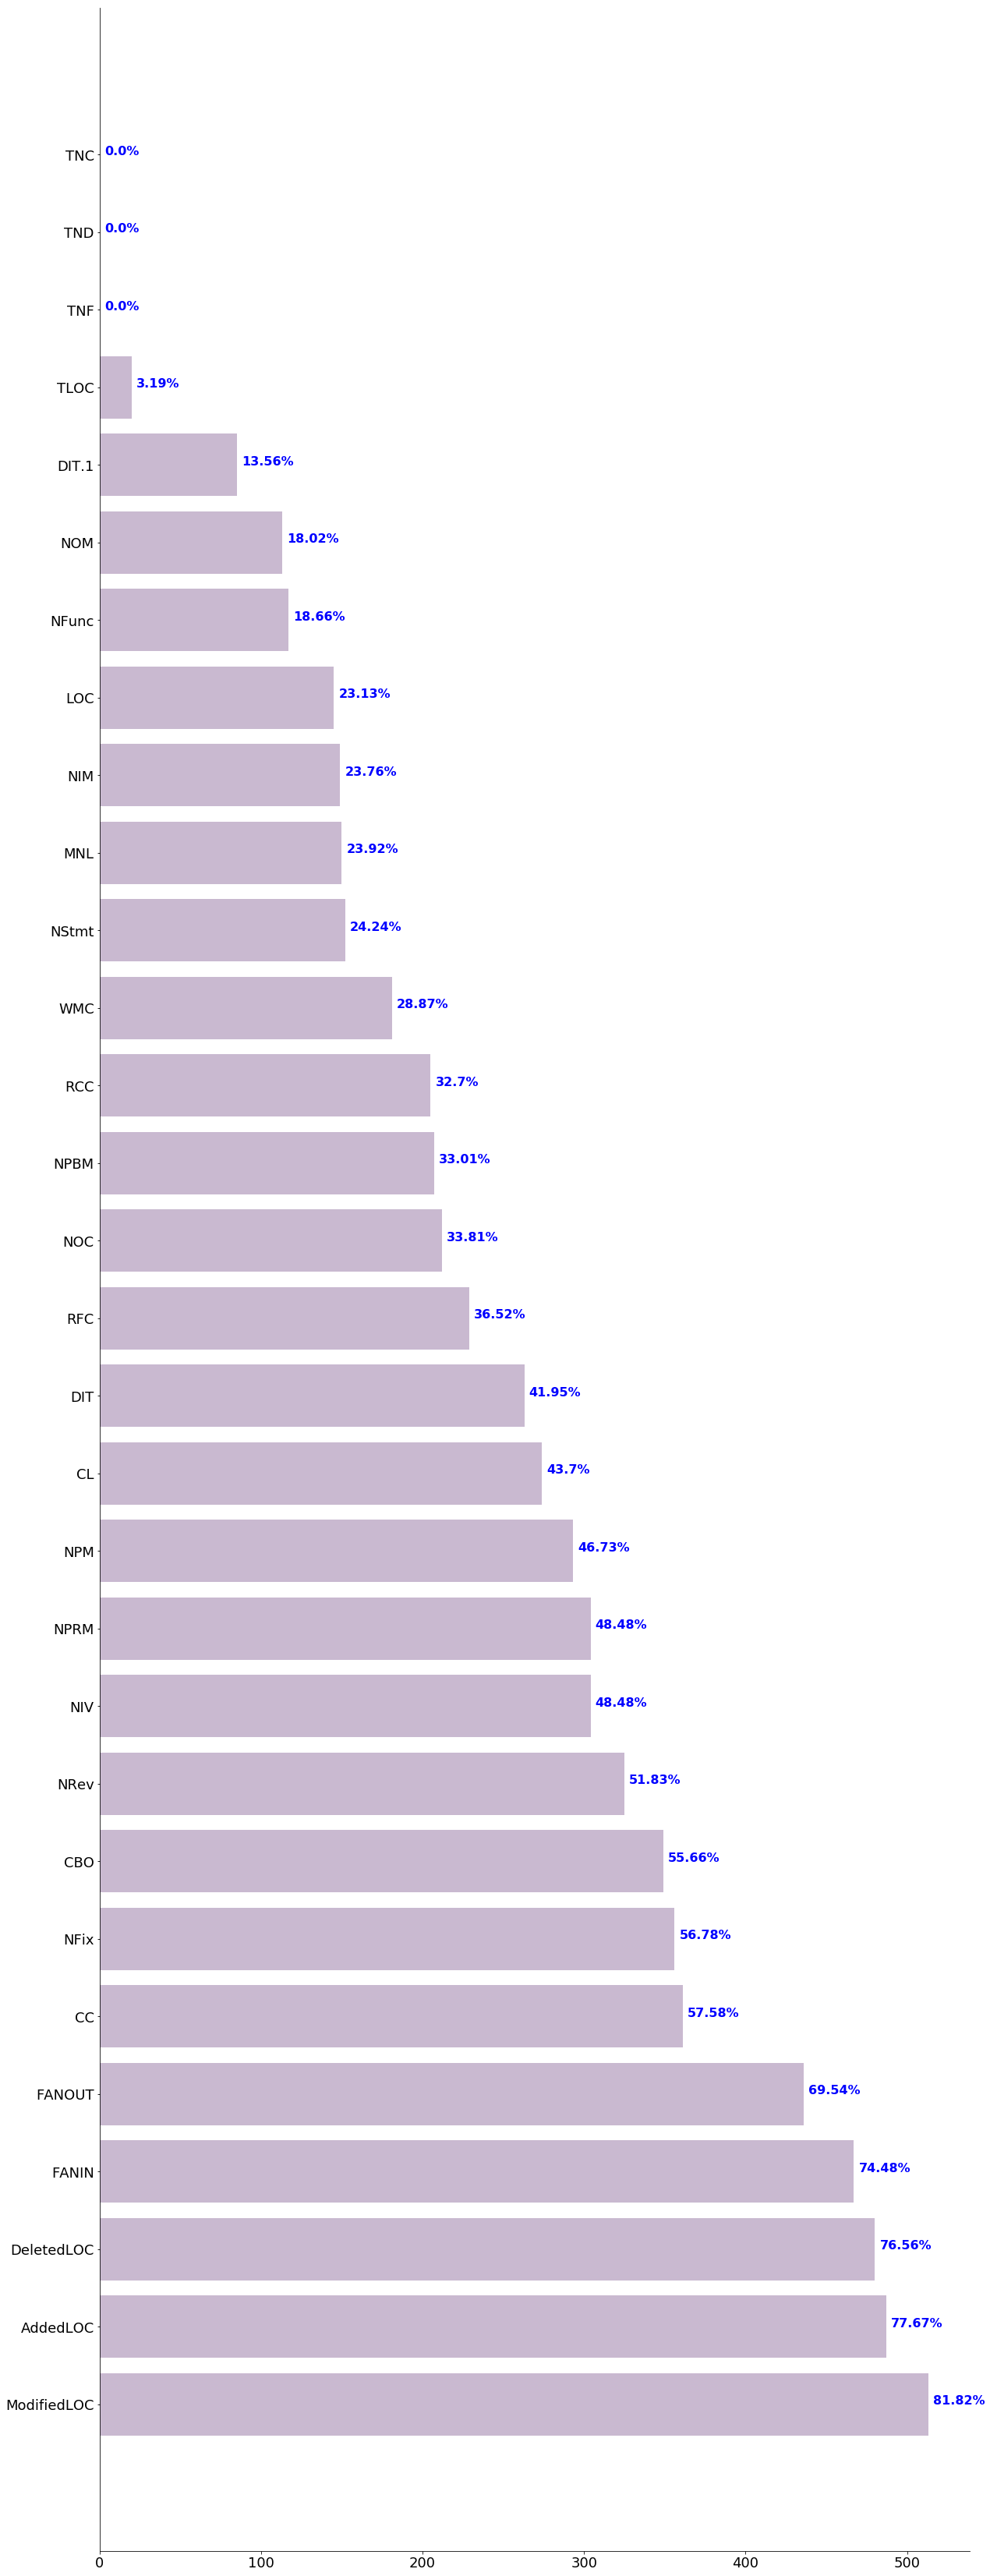

In [8]:
fig, ax = plt.subplots(figsize=(20, 60))    
y_pos = range(len(items_df)-1)
y = items_df.sort_values(by=['ob'],ascending=False)
ax.barh(y.index.tolist()[1:], y.ob.values.tolist()[1:],color = (0.3,0.1,0.4,0.3))
ax.set_yticks(y_pos, y.index.tolist()[1:])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
for i in range(len(y.ob.values.tolist()[1:])):
    v = y.ob.values.tolist()[1:][i]
    ax.text(v + 3, i, str(round((v/627)*100,2)) + '%', color='blue', fontweight='bold',fontsize=16)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

([<matplotlib.patches.Wedge at 0x1a27f5b080>,
 [Text(1.0723824216683837, 0.2449406901612162, 'ModifiedLOC'),
  Text(0.8674471410488492, 0.6764136733435968, 'AddedLOC'),
  Text(0.5130475233283412, 0.9730273576866456, 'DeletedLOC'),
  Text(0.07769806028213401, 1.097252482990307, 'FANIN'),
  Text(-0.35079897414646694, 1.0425641849487188, 'FANOUT'),
  Text(-0.6860538865996031, 0.8598430465390641, 'CC'),
  Text(-0.9179964787602817, 0.6060383362327205, 'NFix'),
  Text(-1.058699129578808, 0.29859027617970835, 'CBO'),
  Text(-1.0997770138634906, -0.022147681086371215, 'NRev'),
  Text(-1.0523325125899288, -0.3203065452752529, 'NIV'),
  Text(-0.9310396286235723, -0.5858030470495019, 'NPRM'),
  Text(-0.7480807534665055, -0.806458421924519, 'NPM'),
  Text(-0.527049019283965, -0.9655150600958076, 'CL'),
  Text(-0.28768418580340593, -1.0617145610938146, 'DIT'),
  Text(-0.05414725492595159, -1.098666498435255, 'RFC'),
  Text(0.15762945661807035, -1.0886473048725616, 'NOC'),
  Text(0.35353593972639047

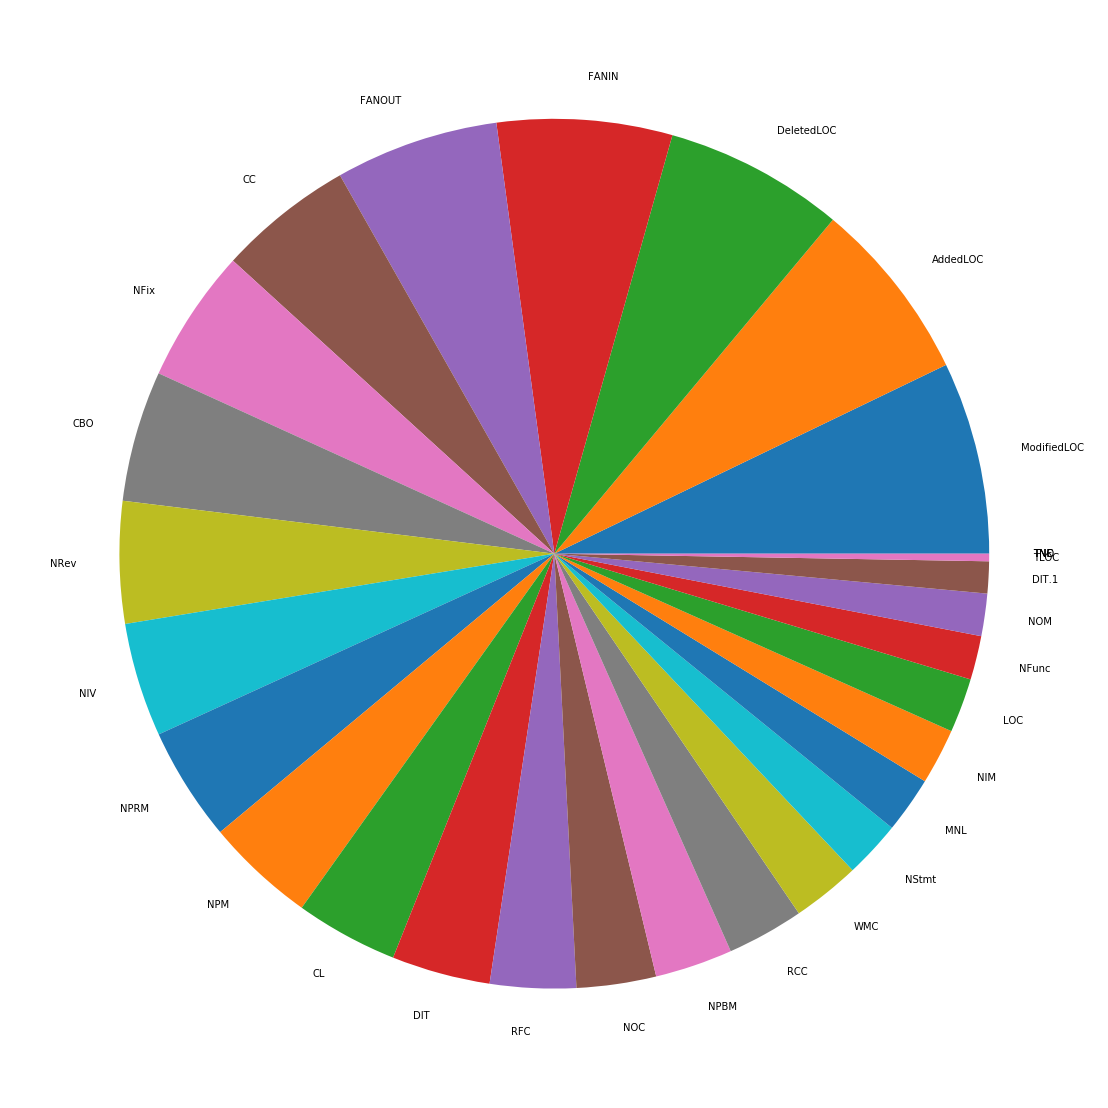

In [9]:
fig, ax = plt.subplots(figsize=(20, 20))    
y_pos = range(len(items_df)-1)
explode = (0, 0.1, 0, 0)
y = items_df.sort_values(by=['ob'],ascending=False)
plt.pie(y.ob.values.tolist()[1:],labels=y.index.tolist()[1:])

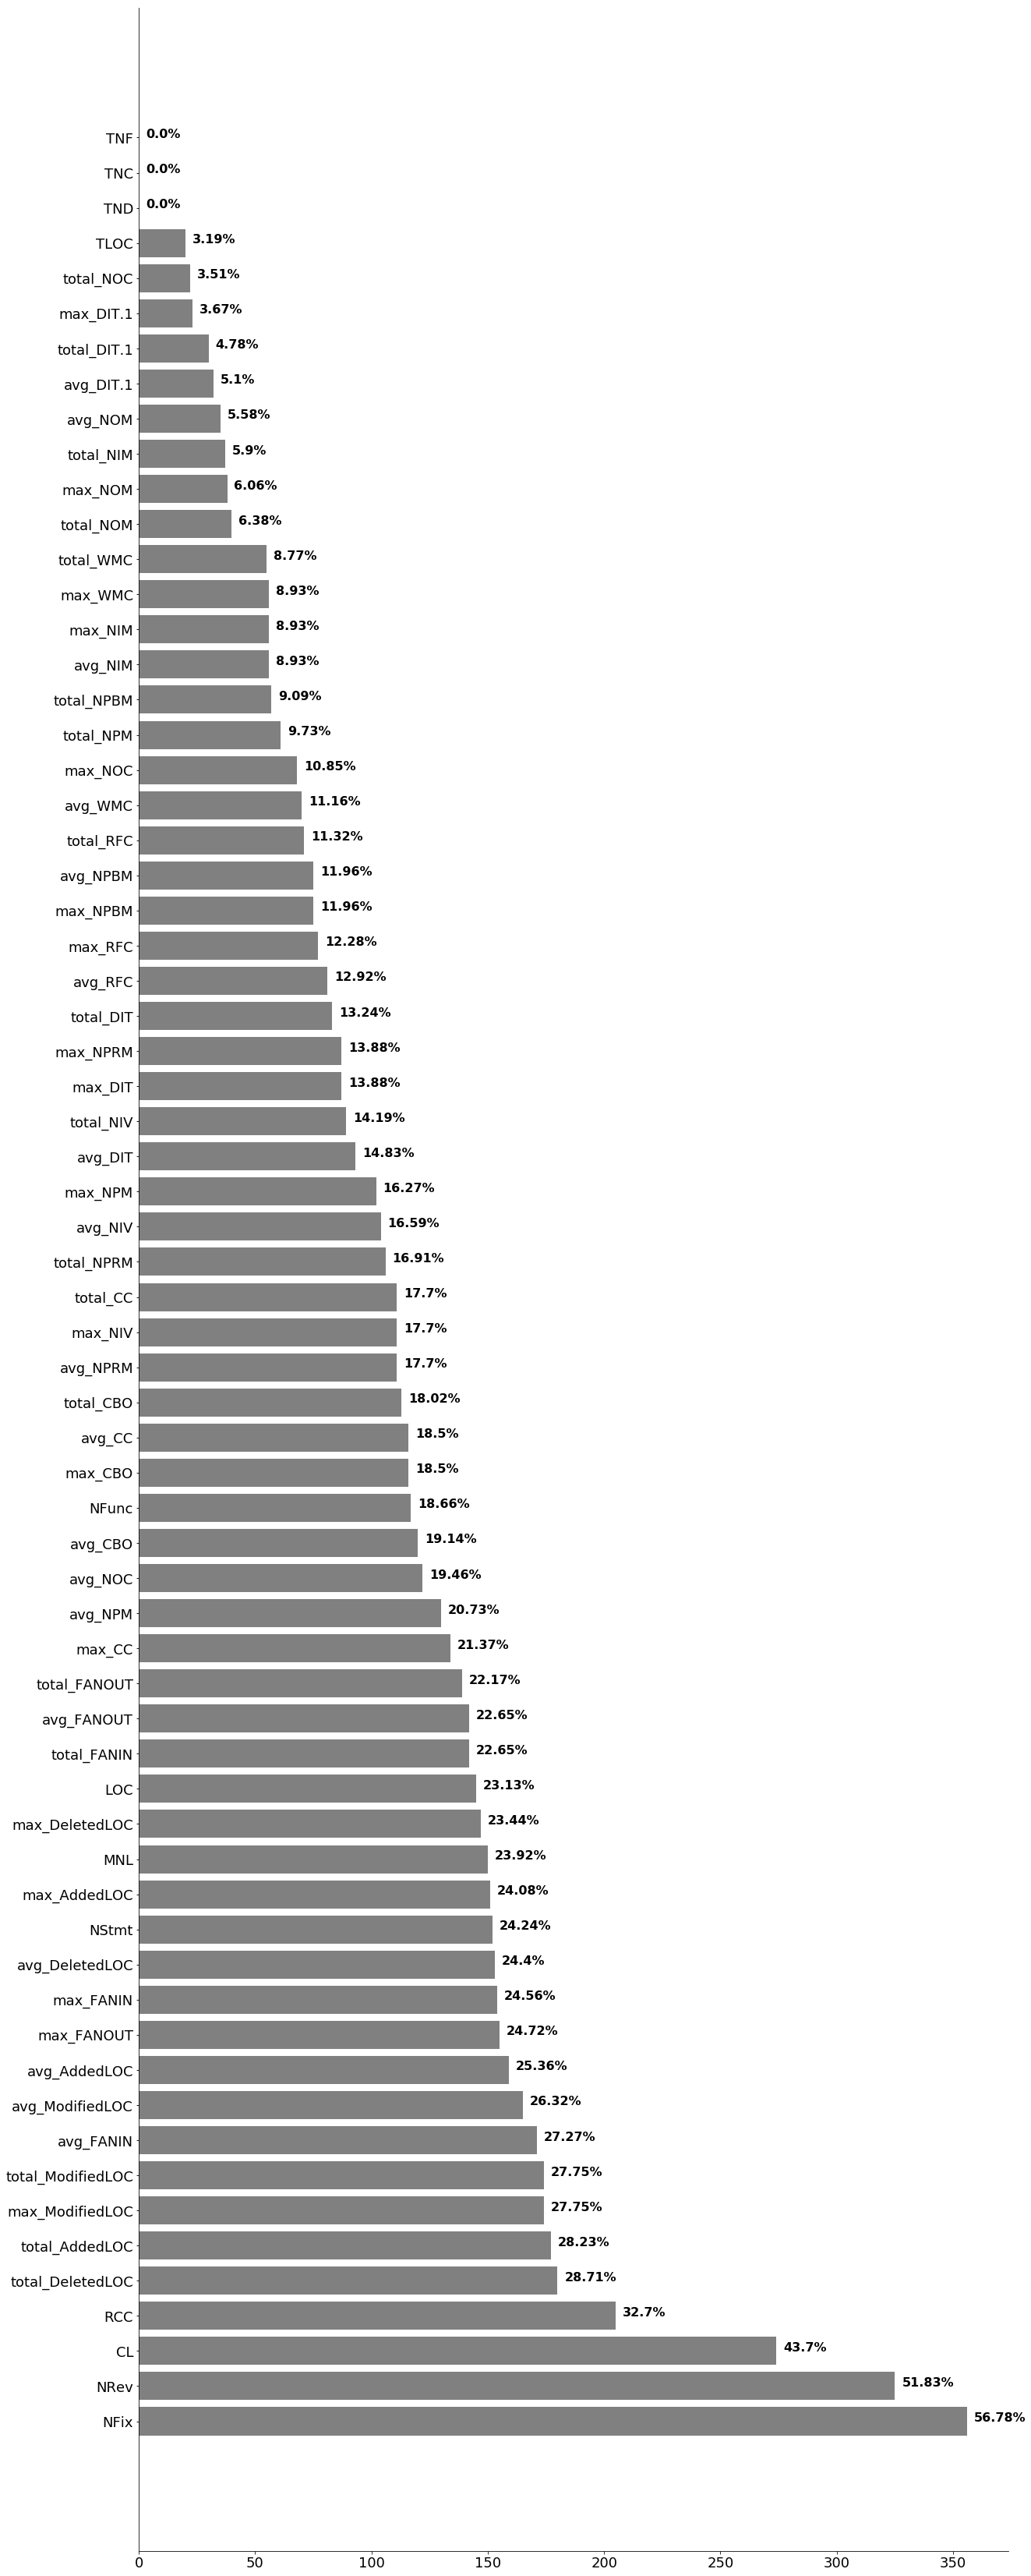

In [10]:

fig, ax = plt.subplots(figsize=(20, 60))    
y_pos = range(len(final_df.iloc[0].values.tolist())-1)
y = final_df.iloc[0].sort_values(ascending=False)
ax.barh(y.index.tolist()[1:], y.values.tolist()[1:],color = 'gray')
ax.set_yticks(y_pos, y.index.tolist()[1:])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
for i, v in enumerate(y[1:]):
    ax.text(v + 3, i, str(round((v/627)*100,2)) + '%', color='black', fontweight='bold',fontsize=16)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

In [1]:
fig, ax = plt.subplots(figsize=(30, 10)) 
x_pos = range(len(final_df.iloc[0].values.tolist())-1)
y = final_df.iloc[0].sort_values(ascending=False)
barlist = plt.bar(y.index.tolist()[1:], y.values.tolist()[1:],color = 'darkgray')
ax.set_xticks(x_pos, y.index.tolist()[1:])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
for i in range(len(y.values.tolist()[1:])):
    v = y.values.tolist()[1:][i]
    z = y.values.tolist()[1:][i]
    ax.text(i-0.25,v+25 , str(int(round((v/627)*100,0))) + '%', color='blue', fontweight='bold',fontsize=16,rotation='vertical')
    #ax.text(i-0.25,v+25 , str(i) + '%', color='blue', fontweight='bold',fontsize=16,rotation='vertical')
barlist[7].set_color('red')
barlist[27].set_color('red')
barlist[30].set_color('red')
barlist[42].set_color('red')
barlist[43].set_color('red')
barlist[44].set_color('red')
barlist[46].set_color('red')
barlist[49].set_color('red')
plt.xticks(fontsize=18,rotation='vertical')
plt.yticks(fontsize=18)
#plt.show()
plt.savefig('fss.pdf',dpi=600)

NameError: name 'plt' is not defined

In [ ]:
def get_predicted_bell(cluster_data_loc,metrices_loc,fold,data_location):
    train_data = pd.read_pickle(cluster_data_loc + '/train_data.pkl')
    bellwether_df = pd.read_csv(cluster_data_loc + '/bellwether_cdom_0.csv')
    bellwether = bellwether_df.bellwether.values.tolist()[0]
    project = train_data.index.values.tolist()
    _s_path = '/Users/suvodeepmajumder/Documents/AI4SE/bellwether_comminity/data/1385/converted/' + project[0]
    s_df = prepare_data(_s_path)
    s_cols = s_df.columns
    return train_data.loc[bellwether].tolist(),s_cols

In [ ]:
final_list_bell = []
for i in range(1):
    fold = str(i)
    data_location = '/Users/suvodeepmajumder/Documents/AI4SE/bellwether_comminity/src/data/1385/exp_cdom_v6/fold_' + fold
    cluster_data_loc = '/Users/suvodeepmajumder/Documents/AI4SE/bellwether_comminity/src/data/1385/new_bellwether_pre_re_pf_v2/2/fold_' + fold
    metrices_loc = '/Users/suvodeepmajumder/Documents/AI4SE/bellwether_comminity/data/1385/converted'
    results,s_cols_bell = get_predicted_bell(cluster_data_loc,metrices_loc,fold,data_location)
    final_list_bell.append(results)
final_df_bell = pd.DataFrame(final_list_bell,columns=s_cols_bell)


In [ ]:
fig, ax = plt.subplots(figsize=(20, 60))    
y_pos = range(len(final_df_bell.iloc[0].values.tolist())-1)
y = final_df_bell.sum().sort_values(ascending=False)
ax.barh(y.index.tolist()[1:], y.values.tolist()[1:],color = (0.3,0.1,0.4,0.3))
ax.set_yticks(y_pos, y.index.tolist()[1:])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
for i, v in enumerate(y[1:]):
    ax.text(v + 1, i, str(round((v/20)*100,2)) + '%', color='blue', fontweight='bold',fontsize=16)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

In [ ]:
plt.figure(figsize=(60, 20))
y_pos = range(len(final_df_bell.iloc[0].values.tolist()))
#y = [x / 20 for x in final_df_bell.sum().values.tolist()]
y = final_df_bell.sum().values.tolist()
plt.bar(final_df_bell.columns.tolist(), y)
plt.xticks(y_pos, final_df_bell.columns.tolist(), rotation=90)

In [ ]:
def get_coefs_bell(cluster_data_loc,metrices_loc,fold,data_location):
    train_data = pd.read_pickle(cluster_data_loc + '/train_data.pkl')
    bellwether_df = pd.read_csv(cluster_data_loc + '/bellwether_cdom_0.csv')
    bellwether = bellwether_df.bellwether.values.tolist()[0]
    project = train_data.index.values.tolist()
    _s_path = '/Users/suvodeepmajumder/Documents/AI4SE/bellwether_comminity/data/1385/converted/' + bellwether
    df = prepare_data(_s_path)
    df.reset_index(drop=True,inplace=True)
    d = {'buggy': True, 'clean': False}
    df['Buggy'] = df['Buggy'].map(d)
    df, s_cols = apply_cfs(df)
    df = apply_smote(df)
    y = df.Buggy
    X = df.drop(labels = ['Buggy'],axis = 1)
    clf_bellwether = LogisticRegression()
    clf_bellwether.fit(X,y)
    print(clf_bellwether.coef_,s_cols[:-1])
    coef = {}
    i = 0
    for col in s_cols[:-1]:
        coef[col] = clf_bellwether.coef_[0][i]
        i += 1
    return coef

In [ ]:
final_list_bell = {}
for i in range(10,11):
    fold = str(i)
    data_location = '/Users/suvodeepmajumder/Documents/AI4SE/bellwether_comminity/src/data/1385/exp_cdom_v6/fold_' + fold
    cluster_data_loc = '/Users/suvodeepmajumder/Documents/AI4SE/bellwether_comminity/src/data/1385/new_bellwether_pre_re_pf_v2/2/fold_' + fold
    metrices_loc = '/Users/suvodeepmajumder/Documents/AI4SE/bellwether_comminity/data/1385/converted'
    results = get_coefs_bell(cluster_data_loc,metrices_loc,fold,data_location)
    final_list_bell[i] = results


In [ ]:
def get_predicted_1(cluster_data_loc,metrices_loc,fold,data_location):
    train_data = pd.read_pickle(cluster_data_loc + '/imp_selected_attr.pkl')
    train_data_df = pd.DataFrame.from_dict(train_data,orient='index')
    project = train_data_df.index.values.tolist()
    _s_path = '/Users/suvodeepmajumder/Documents/AI4SE/bellwether_comminity/data/1385/converted/' + project[0]
    s_df = prepare_data(_s_path)
    s_cols = s_df.columns
    train_data_df.columns = s_cols 
    imp_f = []
    for col in s_cols:
        x = train_data_df[col]
        imp_f.append(x.values.tolist())
    return train_data_df,s_cols

In [ ]:
def get_predicted_2(cluster_data_loc,metrices_loc,fold,data_location):
    train_data = pd.read_pickle(cluster_data_loc + '/imp_selected_attr.pkl')
    train_data_df = pd.DataFrame.from_dict(train_data,orient='index')
    bellwether_df = pd.read_csv(data_location + '/bellwether_cdom_0.csv')
    bellwether = bellwether_df.bellwether.values.tolist()[0]
    project = train_data_df.index.values.tolist()
    _s_path = '/Users/suvodeepmajumder/Documents/AI4SE/bellwether_comminity/data/1385/converted/' + project[0]
    s_df = prepare_data(_s_path)
    s_cols = s_df.columns
    train_data_df.columns = s_cols 
    imp_f = []
    for col in s_cols:
        x = train_data_df[col]
        imp_f.append(x.values.tolist())
    return train_data_df[bellwether],s_cols

In [ ]:
final_list = []
for i in range(20):
    try:
        fold = str(i)
        data_location  = '/Users/suvodeepmajumder/Documents/AI4SE/bellwether_comminity/src/data/1385/new_bellwether_pre_re_pf_v2/2/fold_' + fold
        cluster_data_loc = '/Users/suvodeepmajumder/Documents/AI4SE/bellwether_comminity/src/data/1385/projects'
        metrices_loc = '/Users/suvodeepmajumder/Documents/AI4SE/bellwether_comminity/data/1385/converted'
        results,s_cols = get_predicted_2(cluster_data_loc,metrices_loc,fold,data_location)
        print(results)
    except:
        continue

In [ ]:
fig = plt.figure(num=None, figsize = (20,20), facecolor='w', edgecolor='k')
i = 0
j = 0
for col in s_cols:
    if i == 10:
        i = 0
    if j == 7:
        j = 0
        i += 1
    x = results[col].values.tolist()
    y = list(filter(lambda a: a != 0, x))
    #y =x
    print(i,j)
    ax = plt.subplot2grid((10,7),(i,j))
    j += 1
    bplot1 = ax.boxplot(y,patch_artist = True,showfliers=False)
    ax.set_title(col,size = 15)

    colors = [(0/255,193/255,195/255)]
    for patch, color in zip(bplot1['boxes'], colors):
        patch.set_facecolor(color)
    for median in bplot1['medians']:
        median.set(color='black', linewidth=2)


In [ ]:
results_df.boxplot()

In [ ]:
len(s_cols)